## 1.Introduction

In this noteook a COVID19 data sample is analysed, which includes the different states of Germany and the corresponding time dependence of age, gender, cases, and deaths. Additionally a data set is given with the geometry of the states. So in the current note book three different topics are investigated

Geographics of cases and deaths: It is known that there are states which are sufferening more than others, e.g. Nordrhein-Westfalen. But it is also known that these are the most populated states in Germany. So it seems interesting to see how the picture changes if one normalises the cases and deaths, e.g. per population of the state or per population density of the state.

Change of infection rate over time: Since the virus is now already since quite some time in Germany, the question arises whether the infection rate changed already compared to the beginning. The doubling time is calculated over different periods of the pandemic.

Age and gender of infected people: It is known that older people are more affected by the virus than younger people. Another question is also whether the gender makes a difference, wwhich is investigated at the end.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # fancy statistics plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import geopandas as gpd
import scipy
from scipy.optimize import curve_fit
import datetime


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
path_to_file_covid = '../input/covid19-tracking-germany/covid_de.csv'
path_to_file_demo  = '../input/covid19-tracking-germany/demographics_de.csv'
path_to_file_shape = '../input/covid19-tracking-germany/de_state.shp'

#getting the data
covid_de  = pd.read_csv(path_to_file_covid, index_col="date", parse_dates=True) #cases and deaths per state and age and sex
demo_de   = pd.read_csv(path_to_file_demo)    # demography file
shape_de2 = gpd.read_file(path_to_file_shape) # geography file

# replace Umlaute
shape_tmp = shape_de2.replace({'Baden-Württemberg' : 'Baden-Wuerttemberg', 'Thüringen' : 'Thueringen' }).copy()
shape_de = shape_tmp.rename(columns={'GEN': 'state'}).copy()

# conversion factor for later
m2tokm2 = 1/1000000

/kaggle/input/covid19-tracking-germany/de_state.shp
/kaggle/input/covid19-tracking-germany/de_county.prj
/kaggle/input/covid19-tracking-germany/de_state.dbf
/kaggle/input/covid19-tracking-germany/de_state.cpg
/kaggle/input/covid19-tracking-germany/covid_de.csv
/kaggle/input/covid19-tracking-germany/de_county.cpg
/kaggle/input/covid19-tracking-germany/de_state.shx
/kaggle/input/covid19-tracking-germany/demographics_de.csv
/kaggle/input/covid19-tracking-germany/de_county.dbf
/kaggle/input/covid19-tracking-germany/de_county.shx
/kaggle/input/covid19-tracking-germany/de_state.prj
/kaggle/input/covid19-tracking-germany/de_county.shp


In [2]:
covid_de.head()

,state,county,age_group,gender,cases,deaths,recovered
date,,,,,,,
2020-03-27,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-03-28,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-04-03,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-10-18,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-10-22,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1


In [3]:
demo_de.head()

,state,gender,age_group,population
0,Baden-Wuerttemberg,female,00-04,261674
1,Baden-Wuerttemberg,female,05-14,490822
2,Baden-Wuerttemberg,female,15-34,1293488
3,Baden-Wuerttemberg,female,35-59,1919649
4,Baden-Wuerttemberg,female,60-79,1182736


## 2.Geography dependence

#### First get the proper projection for area conservation, which is the Lambert Azimuthal Equal Area.

In [4]:
# Set the coordinate reference system (CRS) to EPSG 3035
# Lambert Azimuthal Equal Area -> 3035
shape_de.crs = {'init': 'epsg:3025'}
# print(shape_de.geometry.crs)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**So now visuallise the different population and population densities of the states. The area for the density calculation can be also extracted from the geometry file. The area is the converted to km**2.

## 3.Population and population density

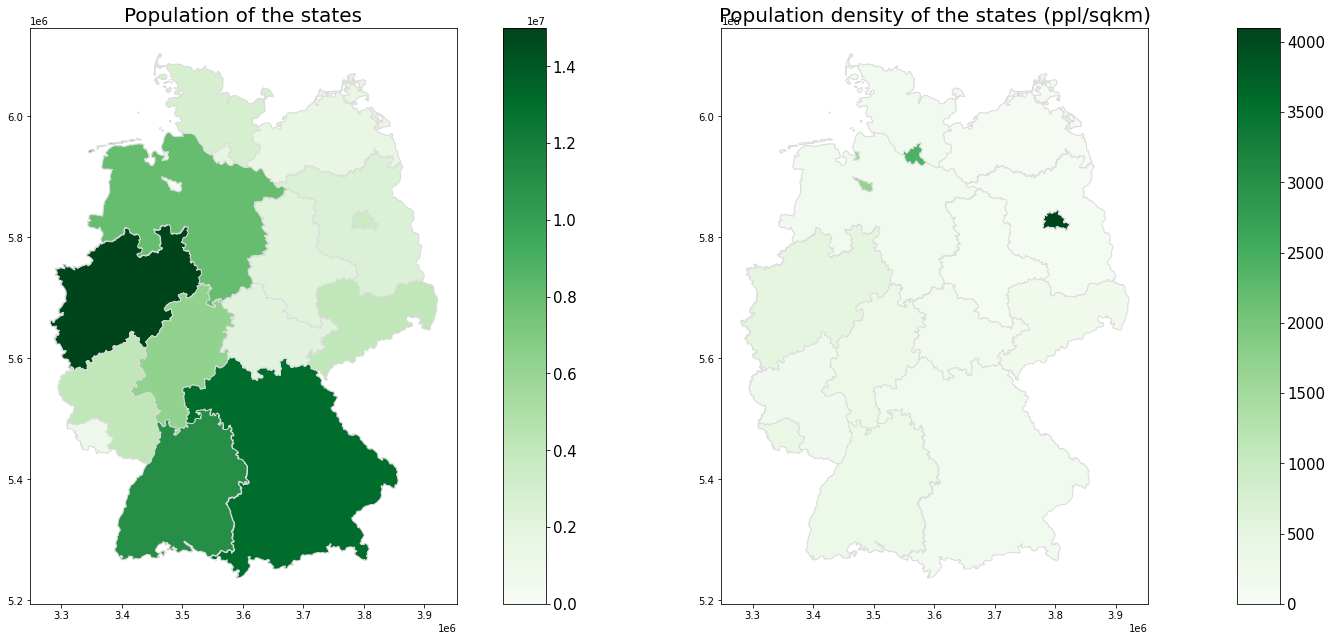

In [5]:
norm_axis1 = 15e6
norm_axis2 = 4.1e3


# map with population
def add_pop_state(state):
    popu = demo_de[demo_de.state == state].population.sum()
    #print(popu)
    shape_de[shape_de.state == state].plot(figsize=(10,10),color= cm.Greens(popu/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

#map with population density
# for this get the area from the polygon, i.e. geometry
def get_area(state):   
    return shape_de[shape_de.state == state].geometry.area

def add_dens_state(state):
    dens  = demo_de[demo_de.state == state].population.sum()/float(get_area(state))/(m2tokm2)
    #print(state , '----' , round((dens)/(m2tokm2),2), 'people/km**2')#properly normalised density people/km**2
    shape_de[shape_de.state == state].plot(figsize=(10,10),color= cm.Greens(dens/norm_axis2), edgecolor='gainsboro', zorder=3, ax =  ax2)
    
    
plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_pop_state(i)
ax1.set_title('Population of the states', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='Greens')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_dens_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='Greens')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Population density of the states (ppl/sqkm)', fontsize=20)

plt.show()

Here once can see, that the population is large in e.g. NRW, but the density is of course much higher in cities.

## 4.Cases and deaths per state

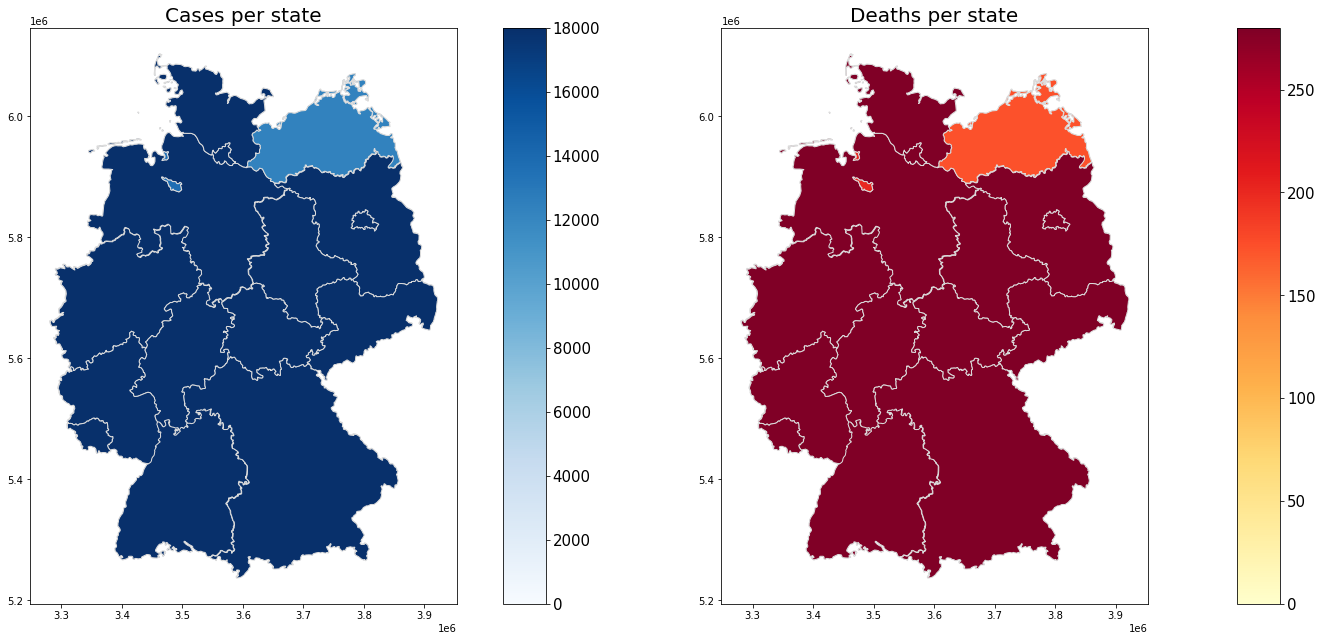

In [6]:
norm_axis1 = 18e3
norm_axis2 = 280

def add_case_per_state(state):
    case = covid_de.loc[covid_de['state'] == state ].cases.sum()
    #print(case)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.Blues(case/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

def add_death_per_state(state):
    death = covid_de.loc[covid_de['state'] == state ].deaths.sum()
    #print(death)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.YlOrRd(death/norm_axis2), edgecolor='gainsboro', zorder=3, ax = ax2)

plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_case_per_state(i)
ax1.set_title('Cases per state', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='Blues')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_death_per_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='YlOrRd')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Deaths per state', fontsize=20)

plt.show()

Cases and deaths do mainly occur in highly populated states. In the following, on can check the normalisation per population and population density. Interesting is also that the eastern part of Germany is much less affected than the eastern part.

## 5.Cases normalised to population

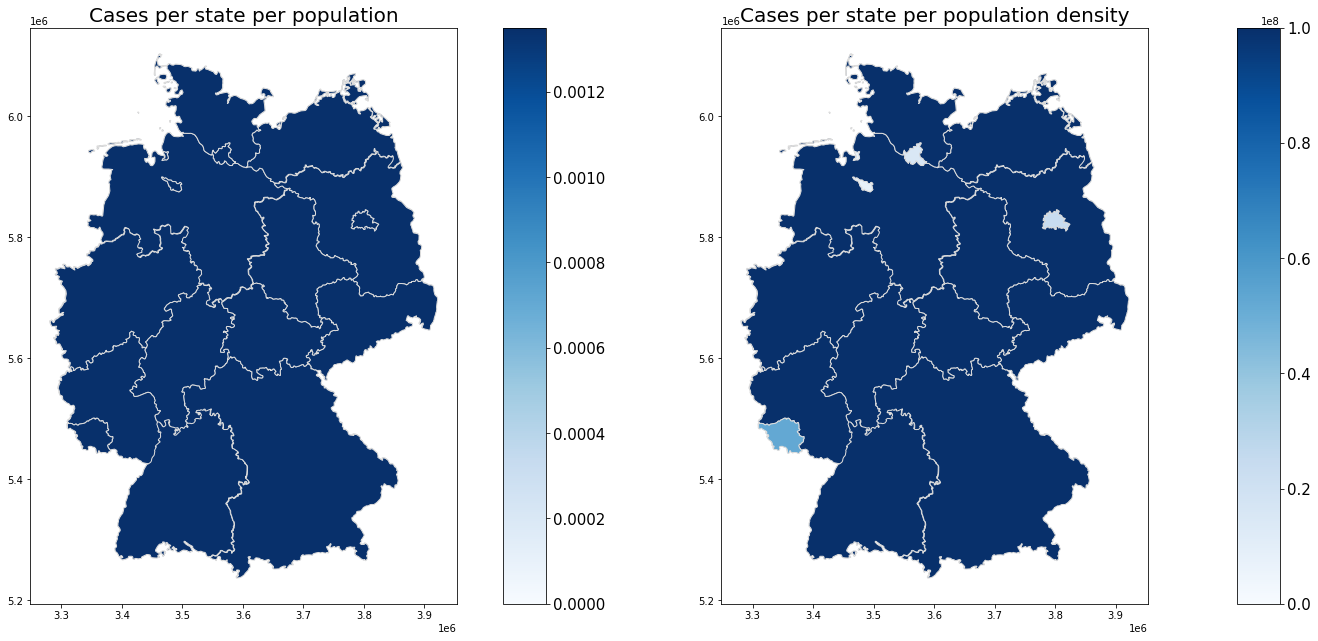

In [7]:
norm_axis1 = 0.00135
norm_axis2 = 1e8


def add_case_per_pop_state(state):
    case_norm = covid_de.loc[covid_de['state'] == state ].cases.sum() / demo_de[demo_de.state == state].population.sum()
    #print(case_norm)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.Blues(case_norm/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

def get_area(state):   
    return shape_de[shape_de.state == state].geometry.area
    
def add_case_per_dens_state(state):
    case_dens = covid_de.loc[covid_de['state'] == state ].cases.sum() / (demo_de[demo_de.state == state].population.sum()/float(get_area(state)))
    #print(case_dens)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.Blues(case_dens/norm_axis2), edgecolor='gainsboro', zorder=3, ax =  ax2)

    

plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_case_per_pop_state(i)
ax1.set_title('Cases per state per population', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='Blues')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_case_per_dens_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='Blues')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Cases per state per population density', fontsize=20)

plt.show()

When dividing by the population (left side), one can see that mainly the south has many cases. When normalising by the population density of the state, Bavaria is leading. this is probably due to the fact that the area is rather large compared to the other states. In the next plot, the same exercise is done with the cases of deaths. But the picture is quite similar.

## 6.Deaths normalised to population

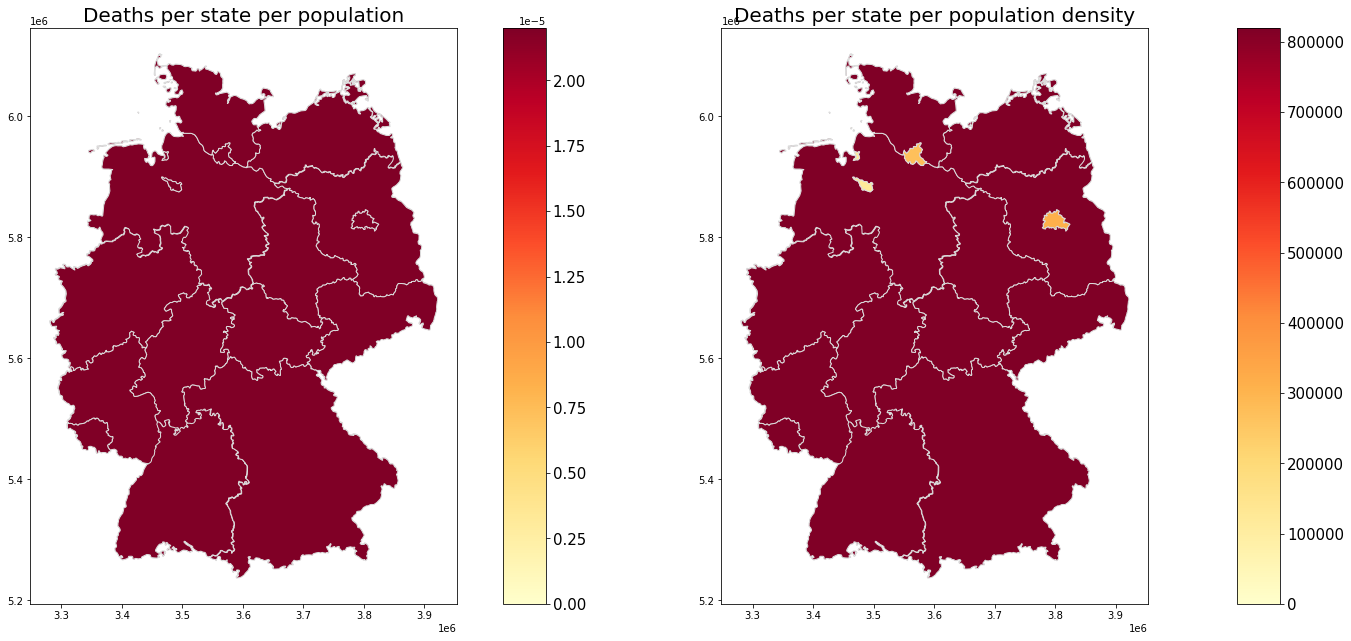

In [8]:
norm_axis1 = 2.2e-05
norm_axis2 = 8.2e5


def add_death_per_pop_state(state):
    death_norm = covid_de.loc[covid_de['state'] == state ].deaths.sum() / demo_de[demo_de.state == state].population.sum()
    #print(death_norm)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.YlOrRd(death_norm/norm_axis1), edgecolor='gainsboro', zorder=3, ax =  ax1)

def get_area(state):   
    return shape_de[shape_de.state == state].geometry.area
    
def add_death_per_dens_state(state):
    death_dens = covid_de.loc[covid_de['state'] == state ].deaths.sum() / (demo_de[demo_de.state == state].population.sum()/float(get_area(state)))
    #print(death_dens)
    shape_de[shape_de.state == state].plot(figsize=(10,10), color= cm.YlOrRd(death_dens/norm_axis2), edgecolor='gainsboro', zorder=3, ax =  ax2)

    

plt.figure() 

# Create a map
ax1 = plt.axes([0., 0., 1., 2.])
shape_de['geometry'].plot(color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax1)
for i in shape_de.state:
    add_death_per_pop_state(i)
ax1.set_title('Deaths per state per population', fontsize=20)

# add colorbar
fig = ax1.get_figure()
cax = fig.add_axes([1.1, 0.0, 0.1, 2.0])
norm = mpl.colors.Normalize(vmin=0,vmax=norm_axis1)
sm = plt.cm.ScalarMappable(norm = norm, cmap='YlOrRd')
sm._A = []
cbar = fig.colorbar(sm, cax=cax , ax=ax1)
cbar.ax.tick_params(labelsize=15)
# Create a second map
ax2 = plt.axes([1.6, 0., 1., 2.])
shape_de['geometry'].plot(figsize=(10,10),color='whitesmoke', edgecolor='gainsboro', zorder=3, ax = ax2)
for i in shape_de.state:
    add_death_per_dens_state(i)
    
# add colorbar
fig2 = ax2.get_figure()
cax2 = fig.add_axes([2.8, 0.0, 0.1, 2.])
norm2 = mpl.colors.Normalize(vmin=0,vmax=norm_axis2)
sm2 = plt.cm.ScalarMappable(norm=norm2,cmap='YlOrRd')
sm2._A = []
cbar = fig.colorbar(sm2, cax=cax2)
cbar.ax.tick_params(labelsize=15)
ax2.set_title('Deaths per state per population density', fontsize=20)

plt.show()

The following lines are just to make sure that the higher death rate in Bayern and Baden-Wuerttemberg are not a consequence of the increased average age of the population compared to other states. But this is not the case as one can see below. The numbers are comprable to the other states (except cities like e.g. Berlin)

In [9]:
print('Age 60-79-------------')
print(covid_de[covid_de.age_group == '60-79'].groupby('state').cases.sum() /  covid_de.groupby('state').cases.sum() )
print('Age 80-99-------------')
print(covid_de[covid_de.age_group == '80-99'].groupby('state').cases.sum() /  covid_de.groupby('state').cases.sum() )

Age 60-79-------------
state
Baden-Wuerttemberg        0.148610
Bayern                    0.147305
Berlin                    0.126011
Brandenburg               0.181582
Bremen                    0.122993
Hamburg                   0.116988
Hessen                    0.138566
Mecklenburg-Vorpommern    0.186570
Niedersachsen             0.134876
Nordrhein-Westfalen       0.134811
Rheinland-Pfalz           0.147659
Saarland                  0.171100
Sachsen                   0.199442
Sachsen-Anhalt            0.187384
Schleswig-Holstein        0.139841
Thueringen                0.199006
Name: cases, dtype: float64
Age 80-99-------------
state
Baden-Wuerttemberg        0.086782
Bayern                    0.088780
Berlin                    0.072628
Brandenburg               0.121346
Bremen                    0.058175
Hamburg                   0.077053
Hessen                    0.090865
Mecklenburg-Vorpommern    0.107201
Niedersachsen             0.081560
Nordrhein-Westfalen       0.076764
Rhei

To further look into this picture I checked for outliers for every state. For this I check how many counties deviate strongly from the mean of the counties in a violin plot.

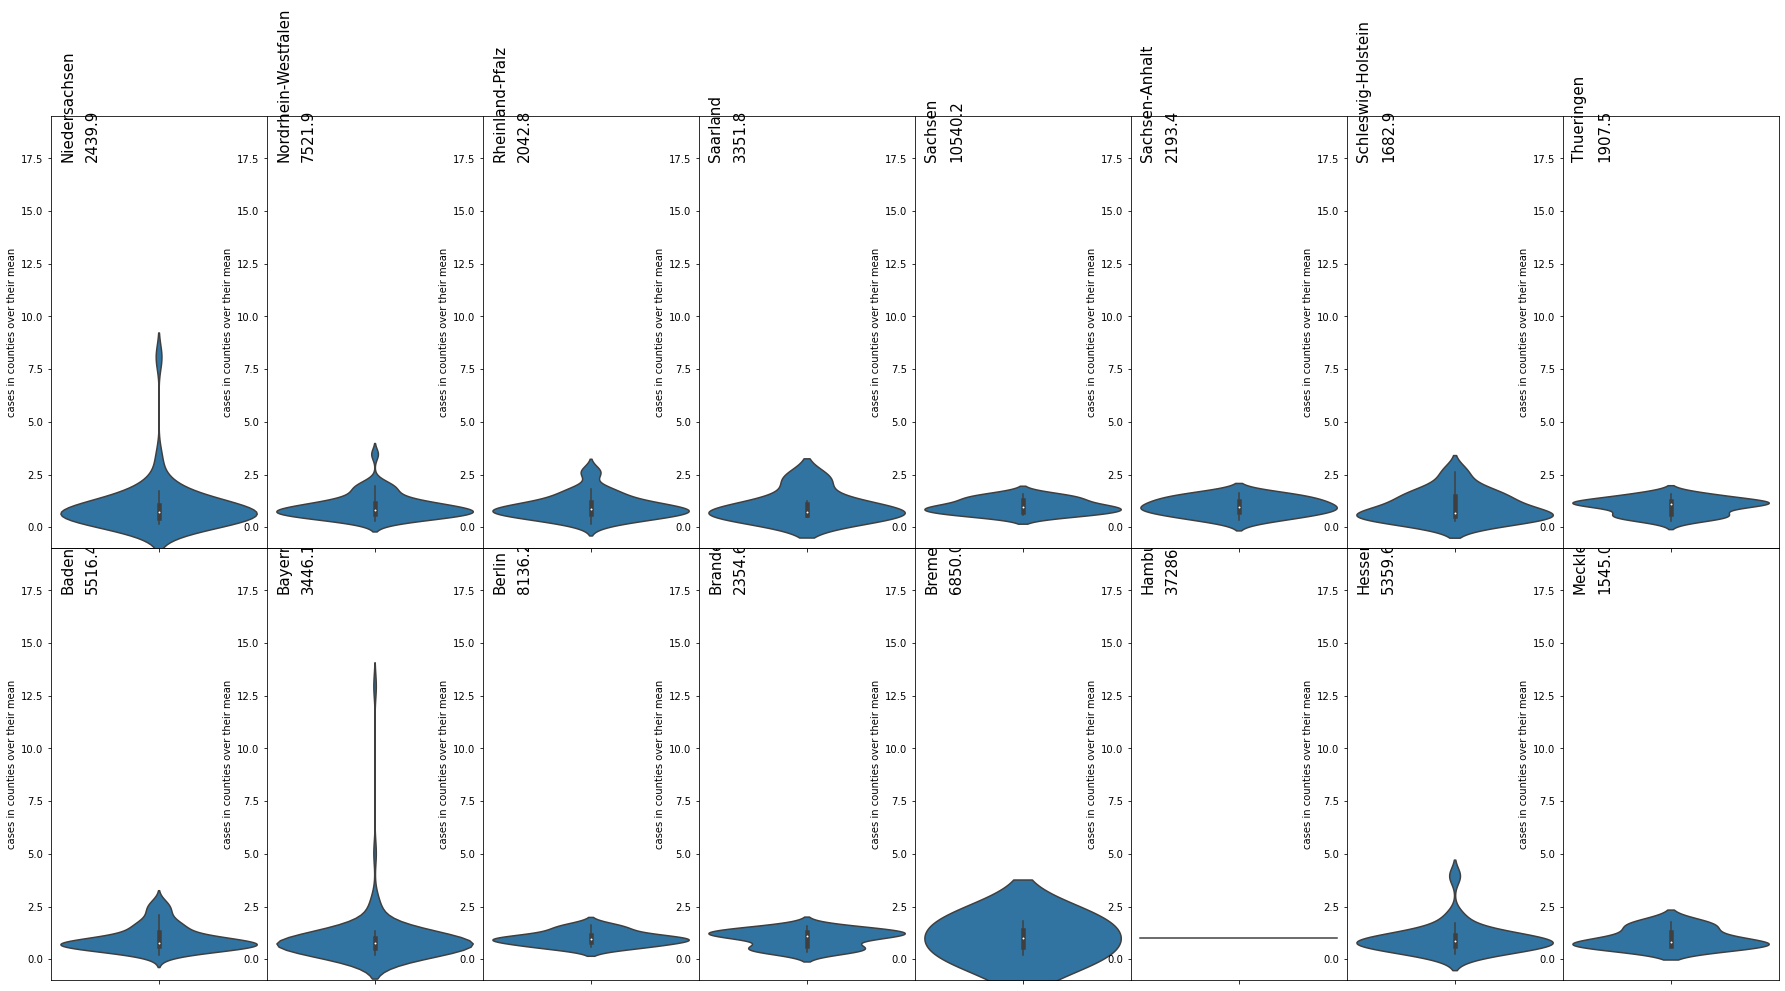

In [10]:
plt.figure() 
shift = 0.
y_min = -1.
y_max =  19.5
angle = 90

for state in covid_de.state.unique():
    if shift < 4:
        #lower panel
        plt.axes([0.+shift,0., 0.5, 1.5])
        plt.ylim(y_min, y_max)
        y_var = covid_de[covid_de.state == state].groupby('county').cases.sum() / covid_de[covid_de.state == state].groupby('county').cases.sum().mean()
        ax1 = sns.violinplot(y=y_var)
        plt.ylabel('cases in counties over their mean')
        ax1.text(-0.4, 17.5, state,rotation=angle, fontsize=15)
        ax1.text(-0.3, 17.5, round(covid_de[covid_de.state == state].groupby('county').cases.sum().mean(),1) ,rotation=angle, fontsize=15)
    else :
        #upper panel
        plt.axes([-4+shift, 1.5, 0.5, 1.5])
        plt.ylim(y_min, y_max)
        y_var = covid_de[covid_de.state == state].groupby('county').cases.sum() / covid_de[covid_de.state == state].groupby('county').cases.sum().mean()
        ax1 = sns.violinplot(y=y_var)
        plt.ylabel('cases in counties over their mean')
        ax1.text(-0.4, 17.5, state ,rotation=angle, fontsize=15)
        ax1.text(-0.3, 17.5, round(covid_de[covid_de.state == state].groupby('county').cases.sum().mean(),1) ,rotation=angle, fontsize=15)
    shift += 0.5

One can see that there are states which have significant outliers, i.e. Bayern or also Niedersachen. However the problem with this normalisation is of course that the mean per county (which is shown under the name of the state), also strongly dependends on how many counties are in the state. For example Hamburg has only one 'county', so the number is very high since all the cases are essentially integrated to one number. Anyway, in the the plot of Bavaria it seemed quite surprising. So I wanted to have a look at the 'so-called' hot-spots.

In [11]:
#print 'hot-spots'

for i in covid_de.county.unique():
    if (covid_de[covid_de.county == i].cases.sum()) > 800:
        print(covid_de[covid_de.county == i].state.unique() , '-----',i,'----',covid_de[covid_de.county == i].cases.sum())

['Baden-Wuerttemberg'] ----- LK Alb-Donau-Kreis ---- 4021
['Baden-Wuerttemberg'] ----- LK Biberach ---- 3556
['Baden-Wuerttemberg'] ----- LK Boeblingen ---- 8908
['Baden-Wuerttemberg'] ----- LK Bodenseekreis ---- 3125
['Baden-Wuerttemberg'] ----- LK Breisgau-Hochschwarzwald ---- 4805
['Baden-Wuerttemberg'] ----- LK Calw ---- 4324
['Baden-Wuerttemberg'] ----- LK Emmendingen ---- 3410
['Baden-Wuerttemberg'] ----- LK Enzkreis ---- 5071
['Baden-Wuerttemberg'] ----- LK Esslingen ---- 12905
['Baden-Wuerttemberg'] ----- LK Freudenstadt ---- 2645
['Baden-Wuerttemberg'] ----- LK Goeppingen ---- 5878
['Baden-Wuerttemberg'] ----- LK Heidenheim ---- 2649
['Baden-Wuerttemberg'] ----- LK Heilbronn ---- 7556
['Baden-Wuerttemberg'] ----- LK Hohenlohekreis ---- 2386
['Baden-Wuerttemberg'] ----- LK Karlsruhe ---- 8759
['Baden-Wuerttemberg'] ----- LK Konstanz ---- 4855
['Baden-Wuerttemberg'] ----- LK Loerrach ---- 5823
['Baden-Wuerttemberg'] ----- LK Ludwigsburg ---- 13706
['Baden-Wuerttemberg'] ----- LK

In the above display most hot-spots are cities (SK) and the contry-side places (LK) are reasonably well-known from the beginning, i.e. Heinsberg and Rosenheim.

## 7.Time dependence

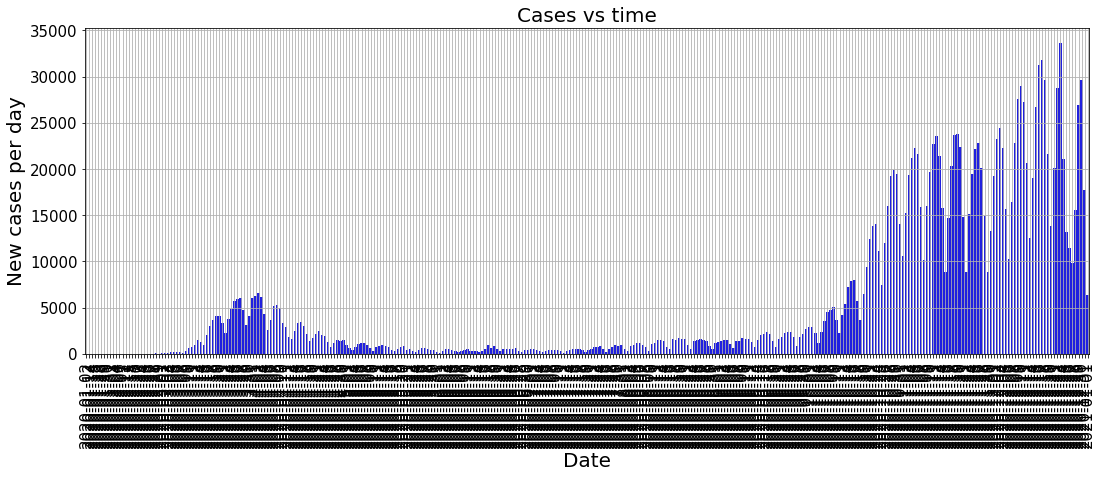

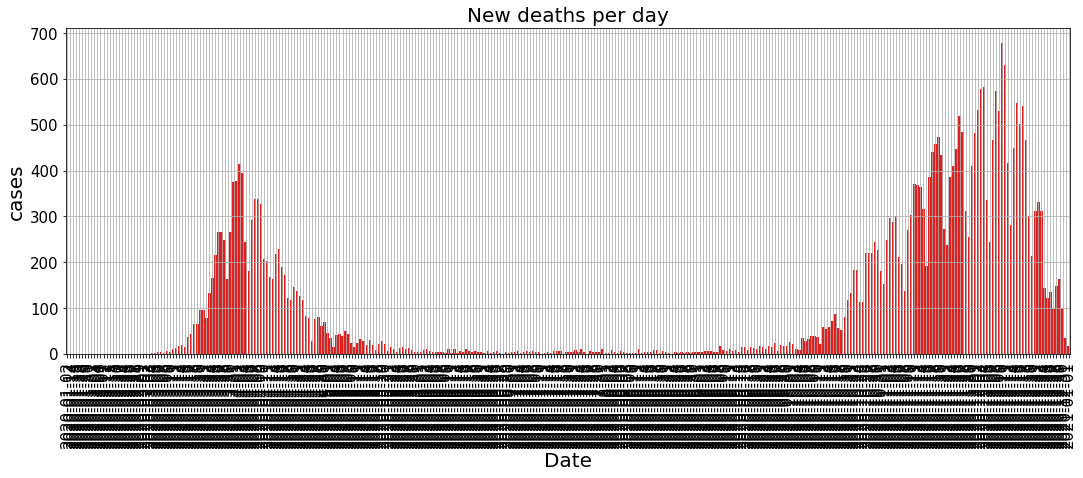

In [12]:
date_comp   = covid_de.index.map(pd.Timestamp.date).unique().sort_values()
case_diff   = covid_de.groupby('date').cases.sum()
deaths_diff = covid_de.groupby('date').deaths.sum()


plt.figure(figsize=(18,6))
ax4 = sns.barplot(x=date_comp, y= case_diff, color = 'blue', ci=None)
ax4.set_xticklabels(labels=ax4.get_xticklabels(),rotation=90)
plt.ylabel('New cases per day', fontsize=20)
plt.xlabel('Date', fontsize=20)
ax4.set_title('Cases vs time', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

plt.figure(figsize=(18,6))
ax5 = sns.barplot(x=date_comp, y= deaths_diff, color = 'red', ci=None)
ax5.set_xticklabels(labels=ax4.get_xticklabels(),rotation=90)
ax5.set_title('New deaths per day', fontsize=20)
plt.ylabel('cases', fontsize=20)
plt.xlabel('Date', fontsize=20)
ax5.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)

Now, one can calculate the integrals over time and fit them in different ranges with an exponential function to look how the infection rate changes as a function of the time.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


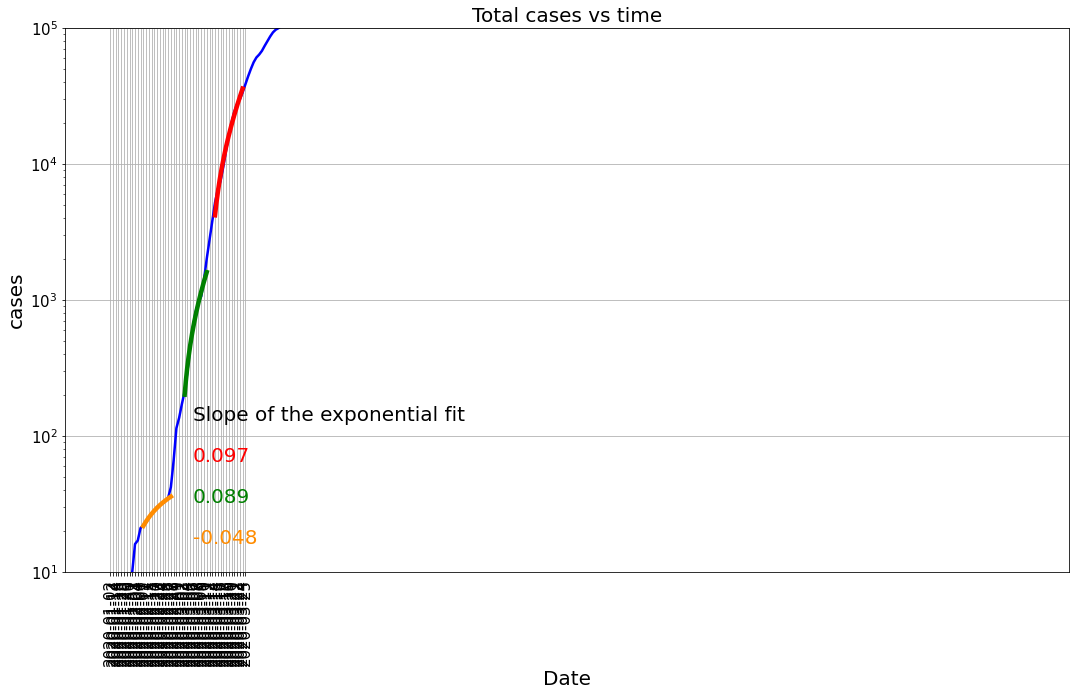

In [13]:
#integral function
def f_int_case(j):
    return covid_de.groupby('date').cases.sum().iloc[1:j].sum()

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def fit_expfunc(start,stop):
    x_range = x_var[start:stop].copy()
    y_fit   = int_case[start:stop].copy()
    exp_val, cova = scipy.optimize.curve_fit(lambda t,a,b,c: a*np.exp(b*t)+c,  x_range,  y_fit,  p0=(4, -0.1, 100))
    xspace  = np.linspace(start, stop, 1000)
    return exp_val, xspace
    
date_tmp = covid_de.index.map(pd.Timestamp.date).unique().sort_values()
x_var = [i for i in range(len(date_comp))]#translate to numbers, easier...
int_case = [f_int_case(i) for i in range(len(date_tmp))]

exp1, xspace1 = fit_expfunc(12,22)
exp2, xspace2 = fit_expfunc(27,35)
exp3, xspace3 = fit_expfunc(38,48)

#line plot + fits
plt.figure(figsize=(18,10))
plt.grid(True)
ax6 = sns.lineplot(x=x_var, y=int_case, color = 'blue',  linewidth=2.5, ci=None)
plt.plot(xspace1, exponential(xspace1, *exp1), color='darkorange', linewidth=4.5)
plt.plot(xspace2, exponential(xspace2, *exp2), color='green', linewidth=4.5)
plt.plot(xspace3, exponential(xspace3, *exp3), color='red', linewidth=4.5)
plt.ylim(1e1,1e5)
ax6.text(30,128, 'Slope of the exponential fit' , fontsize=20)
ax6.text(30,64,  round(exp3[1],3) , fontsize=20,color='red')
ax6.text(30,32,  round(exp2[1],3) , fontsize=20,color='green')
ax6.text(30,16,  round(exp1[1],3) , fontsize=20,color='darkorange')
plt.xticks(np.arange(0, 50, 1))
ax6.set_xticklabels(date_tmp, rotation = 90)
plt.ylabel('cases', fontsize=20)
plt.xlabel('Date', fontsize=20)
ax6.set_title('Total cases vs time', fontsize=20)
ax6.tick_params(axis='both', which='major', labelsize=15)
ax6.set(yscale="log")
plt.draw()

So it actutally seems that the exponential slope of the infection rate is deacreasing compared to a month ago. Although one could also evaluate the uncertainties a little bit more carefully using the covariance matrix, the numbers seem significant.

## 8.Doubling of infections

**With the slope one can also calculate the increase of the time which it takes to dublicate the number of infections via the following**

In [14]:
print('Doubling time-------------')
print('--------------------------')
print('End February/Beginning March: ', round(np.log(2)/exp1[1],1), ' days')
print('Middle March                : ', round(np.log(2)/exp2[1],1), ' days')
print('End March/Beginning April   : ', round(np.log(2)/exp3[1],1), ' days')
print('--------------------------')

Doubling time-------------
--------------------------
End February/Beginning March:  -14.4  days
Middle March                :  7.8  days
End March/Beginning April   :  7.1  days
--------------------------


## 9.Age and gender dependence

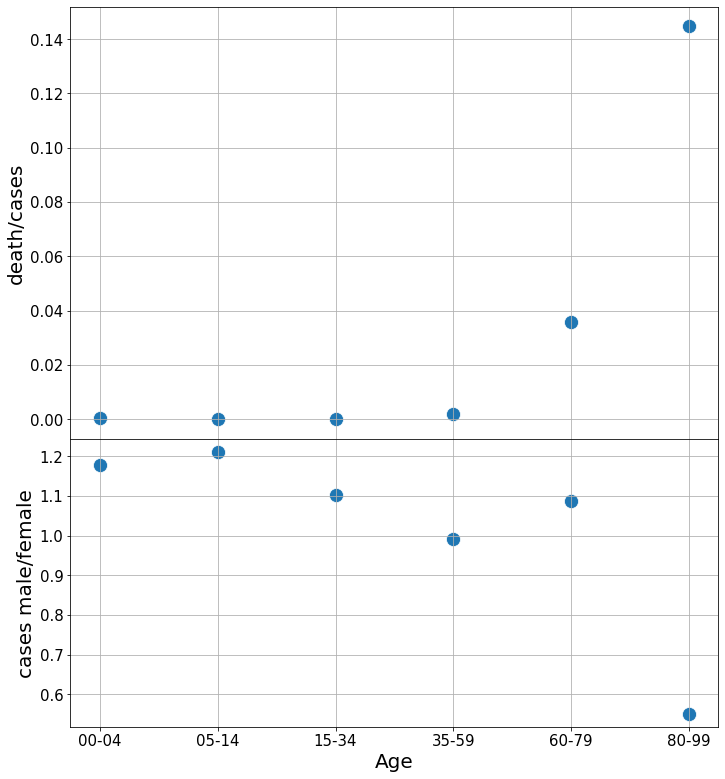

In [15]:
cases_var = [covid_de[covid_de.age_group == i].cases.sum() for i in covid_de.age_group.unique()]
death_var = [covid_de[covid_de.age_group == i].deaths.sum() for i in covid_de.age_group.unique()]

cases_var  = cases_var[:-1]
death_var  = death_var[:-1]
ratio_var  = [death_var[i]/cases_var[i] for i in range(len(death_var))]
age_var    = [i for i in range(len(death_var))]
age_var2   = [i for i in covid_de.age_group.unique()]
age_var2   = age_var2[:-1]
male_var   = [covid_de[covid_de.age_group == i].groupby('gender').cases.sum()[1]/covid_de.groupby('gender').cases.sum()[1] for i in age_var2]
female_var = [covid_de[covid_de.age_group == i].groupby('gender').cases.sum()[0]/covid_de.groupby('gender').cases.sum()[0] for i in age_var2]
ratio_var2 = [male_var[i]/female_var[i] for i in range(len(death_var))]

plt.figure() 
plt.axes([0.,1., 1.5, 1.5])
ax = sns.scatterplot(x=age_var, y=ratio_var, s=200)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('death/cases', fontsize=20)
plt.grid()


plt.axes([0.,0., 1.5, 1.])
ax2 = sns.scatterplot(x=age_var, y=ratio_var2, s=200)
plt.ylabel('cases male/female', fontsize=20)
plt.xlabel('Age', fontsize=20)
age_var2.insert(0,0) # don't know why but the labels have to be shifted
ax2.set_xticklabels(labels = age_var2)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.grid()